# Maximal Coverage Location Problem

*Authors:* [Huanfa Chen](https://github.com/huanfachen)

This notebook is adapted from [this notebook](https://github.com/pysal/spopt/blob/main/notebooks/mclp.ipynb).

LSCP try to minimize the amount of facilities candidate sites in a maximum service standard but then arise another problem: the budget. Sometimes it requires many facilities sites to reach a complete coverage, and there are circumstances when the resources are not available and it's plausible to know how much coverage we can reach using a exact number of facilities. MCLP class try to solve this problem:

_Maximize the amount of demand covered within a maximal service distance or time standard by locating a fixed number of facilities_

**MCLP in math notation:**

$\begin{array} \displaystyle \textbf{Maximize} & \sum_{i=1}^{n}{a_iy_i} && (1) \\
\displaystyle \textbf{Subject to:} & \sum_{j\in N_i}{x_j \geq y_i} & \forall i & (2) \\
            & \sum_{j}{x_j = p} & \forall j & (3) \\
            & y_i \in \{0,1\} & \forall i & (4) \\
            & x_j \in \{0,1\} & \forall j & (5) \\ \end{array}$

$\begin{array} \displaystyle \textbf{Where:}\\ & & \displaystyle i & \small = & \textrm{index referencing nodes of the network as demand} \\
& & j & \small = & \textrm{index referencing nodes of the network as potential facility sites} \\
& & S & \small = & \textrm{maximal acceptable service distance or time standard} \\
& & d_{ij} & \small = & \textrm{shortest distance or travel time between nodes} i \textrm{and} j \\
& & N_i & \small = & \{j | d_{ij} < S\} \\
& & p & \small = & \textrm{number of facilities to be located} \\
& & x_j & \small = & \begin{cases} 
          1, \text{if a facility is located at node } j \\
          0, \text{otherwise} \\
       \end{cases} \\
& & y_i & \small = & \begin{cases} 
              1, \textrm{if demand } i \textrm{ is covered within a service standard} \\
              0, \textrm{otherwise} \\
           \end{cases}\end{array}$
            
_This excerpt above was quoted from Church L., Murray, A. (2018)_


This tutorial solves MCLP using `spopt.locate.coverage.MCLP` instance that depends on a array 2D representing the costs between facilities candidate sites and demand points. For that it uses a lattice 10x10 with simulated points to calculate the costs.

In [15]:
from spopt.locate.coverage import MCLP
from spopt.locate.util import simulated_geo_points

import numpy
import geopandas
import pulp
import spaghetti
from shapely.geometry import Point
import matplotlib.pyplot as plt

Since the model needs a distance cost matrix we should define some variables. In the comments, it's defined what these variables are for but solver. The solver, assigned below as `pulp.PULP_CBC_CMD`, is an interface to optimization solver developed by [COIN-OR](https://github.com/coin-or/Cbc). If you want to use another optimization interface as Gurobi or CPLEX see this [guide](https://coin-or.github.io/pulp/guides/how_to_configure_solvers.html) that explains how to achieve this.

In [16]:
CLIENT_COUNT = 100 # quantity demand points
FACILITY_COUNT = 5 # quantity supply points

SERVICE_RADIUS = 7 # maximum service radius
P_FACILITIES = 4

# Random seeds for reproducibility
CLIENT_SEED = 5 
FACILITY_SEED = 6 

# solver = pulp.PULP_CBC_CMD(msg=False, warmStart=True) # see solvers available in pulp reference
solver = pulp.GLPK_CMD(msg=False)

## Lattice 10x10

Create lattice 10x10 with 9 vertical lines in interior.

In [17]:
lattice = spaghetti.regular_lattice((0, 0, 10, 10), 9, exterior=True)
ntw = spaghetti.Network(in_data=lattice)

Transform spaghetti instance to geopandas geodataframe.

In [18]:
street = spaghetti.element_as_gdf(ntw, arcs=True)

street_buffered = geopandas.GeoDataFrame(
    geopandas.GeoSeries(street["geometry"].buffer(0.2).unary_union),
    crs=street.crs,
    columns=["geometry"],
)

Plotting the network created by spaghetti we can verify that it seems a district with quarters and streets.

<AxesSubplot:>

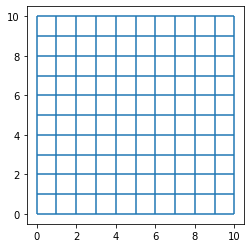

In [19]:
street.plot()

## Simulate points in a network

The function `simulated_geo_points` simulates points inside a network. In this case, it uses a lattice network 10x10 created by using spaghetti package.
Below we use the function defined above and simulate the points inside lattice bounds.

In [20]:
client_points = simulated_geo_points(street_buffered, needed=CLIENT_COUNT, seed=CLIENT_SEED)
facility_points = simulated_geo_points(
    street_buffered, needed=FACILITY_COUNT, seed=FACILITY_SEED
)

Plotting the 100 client and 5 facility points we can see that the function generates dummy points to an area of 10x10 which is the area created by our lattice created on previous cells.

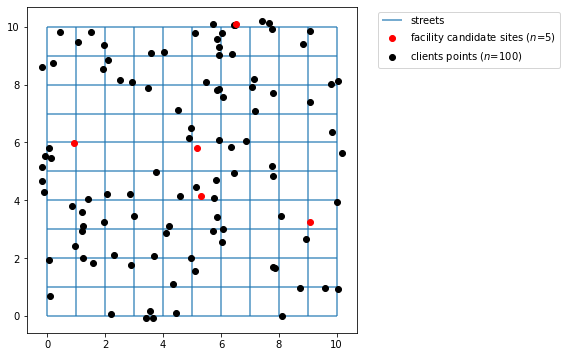

In [21]:
fig, ax = plt.subplots(figsize=(6, 6))
street.plot(ax=ax, alpha=0.8, zorder=1, label='streets')
facility_points.plot(ax=ax, color='red', zorder=2, label='facility candidate sites ($n$=5)')
client_points.plot(ax=ax, color='black', label='clients points ($n$=100)')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

Here, for each client point the model suppose that there is a weight. So, we use randint function from numpy to also simulate these weights.

In [22]:
ai = numpy.random.randint(1, 12, CLIENT_COUNT)

The weight is simulate with a 1-12 range, the minimum is 1 and the maximum is 12.

In [23]:
ai

array([10,  7,  3,  6,  6,  2,  5,  6,  1,  3,  3,  4,  6, 10,  6,  3, 11,
        8,  9,  6,  7, 11, 11, 11,  4,  6,  2,  3,  4,  7, 10, 10,  9,  1,
       11,  4,  8,  5,  9,  2,  3,  5,  2,  6,  6,  7,  2, 10,  1,  6, 11,
        9, 10,  2,  3,  3, 10,  6, 11,  5,  2,  7,  4,  2,  5, 10,  9, 11,
       11, 11,  5,  7,  3, 10,  7,  3,  6,  3,  8,  6,  2,  2,  8,  6,  5,
        3,  9,  9,  8,  9,  1, 11,  9, 10,  3,  1,  8,  7,  1,  8])

## Transform simulated points to real points

To use cost matrix or geodataframes we have to pay attention in some details. The client and facility points simulated don't belong to network, so if we calculate the distances now we are supposed to receive a wrong result. Before calculating distances we snap points to the networok and then calculate the distances.

Below we snap points that is not spatially belong to network and create new real points geodataframes.

In [24]:
ntw.snapobservations(client_points, "clients", attribute=True)
clients_snapped = spaghetti.element_as_gdf(
    ntw, pp_name="clients", snapped=True
)

ntw.snapobservations(facility_points, "facilities", attribute=True)
facilities_snapped = spaghetti.element_as_gdf(
    ntw, pp_name="facilities", snapped=True
)

Now the plot seems more organized as the points belong to network. 
The network created is plotted below with facility points and clients points:

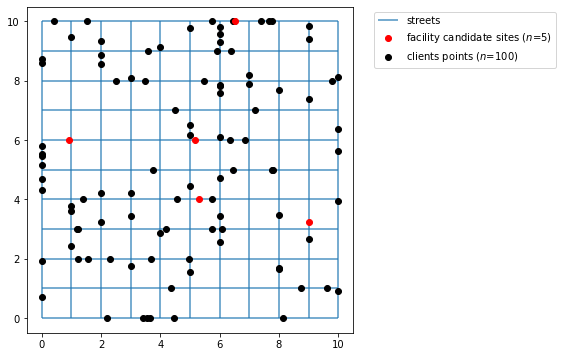

In [25]:
fig, ax = plt.subplots(figsize=(6, 6))
street.plot(ax=ax, alpha=0.8, zorder=1, label='streets')
facilities_snapped.plot(ax=ax, color='red', zorder=2, label='facility candidate sites ($n$=5)')
clients_snapped.plot(ax=ax, color='black', label='clients points ($n$=100)')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

## Calculating the cost matrix 

Calculate distance between clients and facilities.

In [26]:
cost_matrix = ntw.allneighbordistances(
    sourcepattern=ntw.pointpatterns["clients"],
    destpattern=ntw.pointpatterns["facilities"],
)

The expected result here is a Dijkstra distance between clients and facilities points, so we our case an array 2D 100x5.

In [40]:
cost_matrix.shape

(100, 5)

With ``MCLP.from_cost_matrix`` we model the MCL problem to cover all demand points with $p$ facility points within a `max_coverage` meters as service radius using cost matrix calculated previously.

In [28]:
mclp_from_cost_matrix = MCLP.from_cost_matrix(cost_matrix, ai, SERVICE_RADIUS, p_facilities=P_FACILITIES)
result = mclp_from_cost_matrix.solve(solver)

Expected result is an instance of MCLP.

In [29]:
mclp_from_cost_matrix

## Using GeoDataFrame

Assigning predefined location using a geodataframe column

In [30]:
facilities_snapped['predefined_loc'] = numpy.array([1, 1, 0, 1, 0])
facilities_snapped

,id,geometry,comp_label,predefined_loc
0,0,POINT (9.00000 3.25259),0,1
1,1,POINT (0.91963 6.00000),0,1
2,2,POINT (5.31010 4.00000),0,0
3,3,POINT (5.18758 6.00000),0,1
4,4,POINT (6.51169 10.00000),0,0


Assigning service load array to demand geodataframe 

In [31]:
clients_snapped['weights'] = ai

In [32]:
clients_snapped

,id,geometry,comp_label,weights
0,0,POINT (2.00000 8.85562),0,10
1,1,POINT (2.00000 9.35355),0,7
2,2,POINT (5.00000 6.16214),0,3
3,3,POINT (7.76544 5.00000),0,6
4,4,POINT (3.00000 1.75230),0,6
...,...,...,...,...
95,95,POINT (0.00000 4.30248),0,1
96,96,POINT (6.00000 3.42781),0,8
97,97,POINT (2.20274 0.00000),0,7
98,98,POINT (7.40431 10.00000),0,1


With ``MCLP.from_geodataframe`` we model the MCL problem to cover all demand points with $p$ facility points within a `max_coverage` meters as service radius using geodataframes without calculating the cost matrix previously.

In [33]:
mclp_from_geodataframe = MCLP.from_geodataframe(
    clients_snapped, 
    facilities_snapped, 
    "geometry", 
    "geometry", 
    "weights", 
    SERVICE_RADIUS,
    p_facilities=P_FACILITIES,
    distance_metric="euclidean",
)
mclp_from_geodataframe = mclp_from_geodataframe.solve(solver)

Expected result is an instance of MCLP.

In [34]:
mclp_from_geodataframe

## Plotting the results

The cell below describe the plotting of the results. For each method from MCLP class (from_cost_matrix, from_geodataframe) there is a plot displaying the facility site that was selected with a star colored and the points covered with the same color. Sometimes the demand points will be colored with not expected colors, it represents the coverage overlapping.

In [35]:
from matplotlib.patches import Patch
import matplotlib.lines as mlines

dv_colors_arr = [
    "darkcyan",
    "mediumseagreen",
    "cyan",
    "darkslategray",
    "lightskyblue",
    "limegreen",
    "darkgoldenrod",
    "peachpuff",
    "coral",
    "mediumvioletred",
    "blueviolet",
    "fuchsia",
    "thistle",
    "lavender",
    "saddlebrown",
] 

dv_colors = { f"y{i}":dv_colors_arr[i] for i in range(len(dv_colors_arr))}

def plot_results(model, facility_points):
    arr_points = []
    fac_sites = []
    
    for i in range(FACILITY_COUNT):
        if model.fac2cli[i]:

            geom = client_points.iloc[model.fac2cli[i]]['geometry']
            arr_points.append(geom)
            fac_sites.append(i)

    fig, ax = plt.subplots(figsize=(6, 6))
    legend_elements = []

    street.plot(ax=ax, alpha=1, color='black', zorder=1)
    legend_elements.append(mlines.Line2D(
        [],
        [],
        color='black',
        label='streets',
    ))

    facility_points.plot(ax=ax, color='brown', marker="*", markersize=80, zorder=2)
    legend_elements.append(mlines.Line2D(
        [],
        [],
        color='brown',
        marker="*",
        linewidth=0,
        label=f'facility sites ($n$={FACILITY_COUNT})'
    ))

    for i in range(len(arr_points)):
        gdf = geopandas.GeoDataFrame(arr_points[i])

        l = f"y{fac_sites[i]}"

        label = f"coverage_points by y{fac_sites[i]}"
        legend_elements.append(Patch(facecolor=dv_colors[l], edgecolor="k", label=label))

        gdf.plot(ax=ax, zorder=3, alpha=0.7, edgecolor="k", color=dv_colors[l], label=label)
        facility_points.iloc[[fac_sites[i]]].plot(ax=ax,
                                marker="*",
                                markersize=200 * 3.0,
                                alpha=0.8,
                                zorder=4,
                                edgecolor="k",
                                facecolor=dv_colors[l])
        
        legend_elements.append(mlines.Line2D(
            [],
            [],
            color=dv_colors[l],
            marker="*",
            ms=20 / 2,
            markeredgecolor="k",
            linewidth=0,
            alpha=0.8,
            label=f"y{fac_sites[i]} facility selected",
        ))

    plt.title("MCLP", fontweight="bold")
    plt.legend(handles = legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1))

### MCLP built from cost matrix

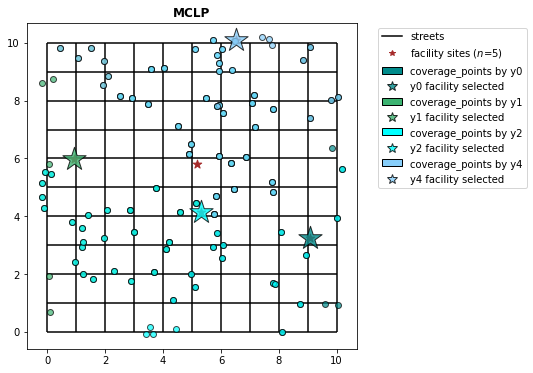

In [36]:
mclp_from_cost_matrix.facility_client_array()
plot_results(mclp_from_cost_matrix, facility_points)

### MCLP built from geodataframes

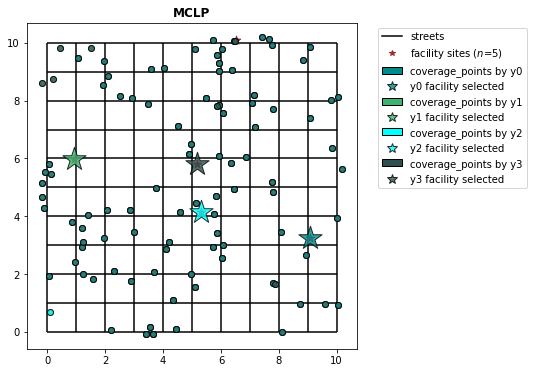

In [37]:
mclp_from_geodataframe.facility_client_array()
plot_results(mclp_from_geodataframe, facility_points)

You may notice that the models are different. This result is expected as the distance between facility and demand points is calculated with different metrics and we are using preselected facilities in geodataframe method. The cost matrix is calculated with dijkstra distance while the distance using geodataframe is calculated with euclidean distance. 

### MCLP built with preselected locations

In [38]:
mclp_from_geodataframe = MCLP.from_geodataframe(
    clients_snapped, 
    facilities_snapped, 
    "geometry", 
    "geometry", 
    "weights", 
    SERVICE_RADIUS,
    predefined_facility_col="predefined_loc",
    p_facilities=P_FACILITIES,
    distance_metric="euclidean",
)
mclp_from_geodataframe = mclp_from_geodataframe.solve(solver)

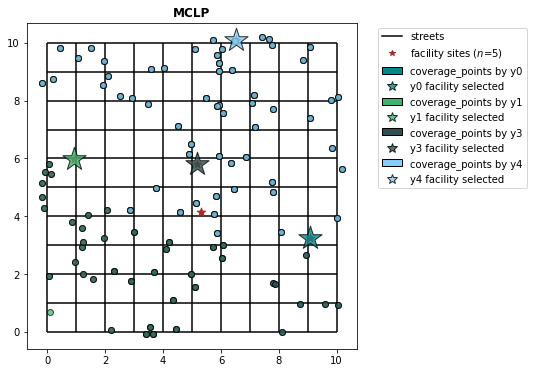

In [39]:
mclp_from_geodataframe.facility_client_array()
plot_results(mclp_from_geodataframe, facility_points)

Here, the differences is explained by the preselected facilities $y_0$, $y_1$ and $y_3$. So, the MCLP model chooses the facility $y_4$ to maximize the coverage given the client points.

## References

- [Church, R. L., & Murray, A. T. (2018). Location covering models: History, applications and advancements (1st edition 2018). Springer](https://www.springer.com/gb/book/9783319998459)